# Local Nadaraya-Watson Regression
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
We start again with the formulation of local polynomial estimators:
    $$\mathcal{L} = \sum_{i=1}^{n}\left(y_{i}-\sum_{j=0}^{p}\beta_{j}(x_{i}-x)^{j}\right)^{2}K_{h}(x_{i}-x),$$
where $\beta$ are the learnable parameters that represent local Taylor expansion coefficients.
The final unique local polynomial regression model we will discuss is when the polynomial order of our basis function is $p=0$ or when the basis functions are bias terms:
    $$\mathcal{L} = \sum_{i=1}^{n}\left(y_{i}-\beta_{0}\right)^{2}K_{h}(x_{i}-x).$$
This method is referred to as the Nadaraya-Watson estimator as it was first proposed by [Nadaraya (1964)](https://epubs.siam.org/doi/abs/10.1137/1109020)
and [Watson (1964)](https://www.jstor.org/stable/25049340?seq=1#metadata_info_tab_contents).
What is convenient about this form is that we can now solve for the estimator function $\hat{\beta}_{0}(x)=\hat{m}(x)$ with out any matrix inversion (there also exists a closed for of local linear regression but was not shown):
    $$\hat{m}(x)=\frac{\sum_{i=1}^{n}K_{h}(x_{i}-x)y_{i}}{\sum_{i=1}^{n}K_{h}(x_{i}-x)},$$
which can be easily found by taking the derivative of the loss with respect to $\beta$ and setting it equal to zero.
Lets again apply this to our favorite regression function:
    $$m(x)=2\exp\left\{-x^{2}/(0.3)^{2}\right\}+3\exp\left\{-(x-1)^{2}/(0.7)^{2}\right\}, \quad x\in[0,1],$$
with output-wise noise added to each observation:
    $$y_{i}=m(x_{i})+0.075\epsilon_{i},\quad \epsilon_{i}\sim\mathcal{N}(0,1).$$

In [1]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt

In [2]:
plt.close("all")
np.random.seed(123)
ntrain = 100 # Number of training points
h = 0.05 # Kernel Bandwidth

# Generate training data
x_train = np.linspace(0,1,ntrain)
Y = 2*np.exp(-x_train**2/(0.3**2)) + 3*np.exp(-(x_train-1)**2/(0.7**2)) + 0.075*np.random.randn(ntrain)

For this lets compare a handful of kernels.
First we will consider the standard Gaussian kernel as we have done in the previous regression examples:
    $$K^{N}_{h}=h^{-1}\mathcal{N}(x/h | 0,1)=\mathcal{N}(x|0,h^{2}).$$
Again, the standard Gaussian kernel is unique because the bandwidth and standard deviation are interchangeable.
We will also take a look at a uniform kernel with a support region $|x/h|\leq 1$:
    $$K^{U}_{h}=h^{-1}\mathcal{U}[x/h |-1,1]=0.5h^{-1}\mathbf{1}_{|x|<1}.$$
which is analogous to a nearest neighbor approximation.
Finally we will again revisit the Epanechnikov kernel with a support region $|x/h|\leq 1$:
    $$K(x)=\frac{3}{4}\left[1-x^{2}\right]\mathbf{1}_{|x|<1}.$$

In [3]:
# Predict
n_pred = 100
x_pred = np.linspace(0,1,n_pred)
m = np.zeros((3, n_pred))
for i, x0 in enumerate(x_pred):
    # Normal Kernel
    m[0,i] = np.sum(norm.pdf(x_train-x0, loc=0, scale=h)*Y) / \
        np.sum(norm.pdf(x_train-x0, loc=0, scale=h))
    # Uniform Kernel (Nearest neighbor)
    m[1,i] = np.sum(uniform.pdf((x_train-x0)/h, loc=-1, scale=2)*Y) / \
        np.sum(uniform.pdf((x_train-x0)/h, loc=-1, scale=2))
    # Epanechnikov Kernel
    m[2,i] = np.sum(0.75*(1-((x_train-x0)/h)**2)*(np.abs((x_train-x0)/h) < 1)*Y) / \
        np.sum(0.75*(1-((x_train-x0)/h)**2)*(np.abs((x_train-x0)/h) < 1))

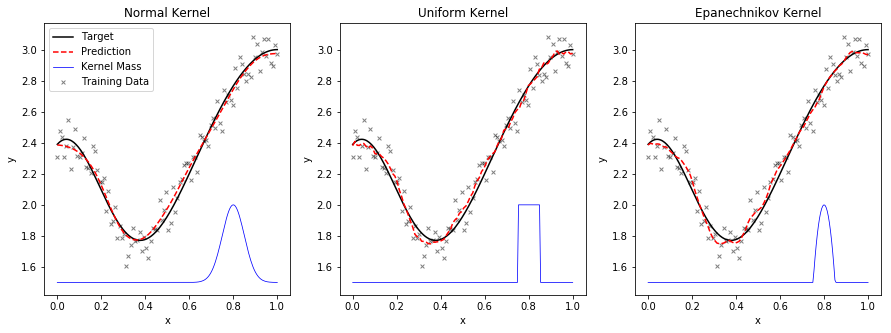

In [4]:
fig = plt.figure(figsize=(15,5))
ax = []
ax.append(plt.subplot2grid((1, 3), (0, 0)))
ax.append(plt.subplot2grid((1, 3), (0, 1)))
ax.append(plt.subplot2grid((1, 3), (0, 2)))

x_target = np.linspace(0,1,200)
y_target = 2*np.exp(-x_target**2/(0.3**2)) + 3*np.exp(-(x_target-1)**2/(0.7**2))

for i, ax0 in enumerate(ax):
    # Plot target
    ax0.plot(x_target, y_target, '-', color='k', label='Target')
    # Prediction
    ax0.plot(x_pred, m[i], '--', color='r', label='Prediction')
    # Training data
    ax0.scatter(x_train, Y, c='k', s=15.0, marker='x', linewidth=1.0, label='Training Data', alpha=0.5)
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')
    
# Plot kernel mass
xmass = np.linspace(0,1,200)
cent = 0.8
k1 = norm.pdf(xmass-cent, loc=0, scale=h)
k2 = uniform.pdf((xmass-cent)/h, loc=-1, scale=2)
k3 = (0.75*(1-((xmass-cent)/h)**2)*(np.abs((xmass-cent)/h) < 1))
ax[0].plot(xmass, 1.5 + 0.5*k1/np.max(k1), c='b', linewidth=0.75, label='Kernel Mass')
ax[1].plot(xmass, 1.5 + 0.5*k2/np.max(k2), c='b', linewidth=0.75, label='Kernel Mass')
ax[2].plot(xmass, 1.5 + 0.5*k3/np.max(k3), c='b', linewidth=0.75, label='Kernel Mass')

ax[0].set_title('Normal Kernel')
ax[1].set_title('Uniform Kernel')
ax[2].set_title('Epanechnikov Kernel')

ax[0].legend()
plt.show()

The black line is the target density, the red line is the prediction by the Nadaraya-Watson estimator and the blue line illustrates the scaled kernel mass.
Overall all three kernels have similar predictions, however the Gaussian is able to yield a smoother prediction due to its wider support region. 